# Milestone Project I: Fantasy Football Analysis
## Tristan Morgan and David Brand

#### List of Requirements:
https://umich.instructure.com/courses/823467/pages/reading-team-project-guidelines?module_item_id=4900067

1. Problem formulation
2. Team formation
3. Selection of data sources
4. Project proposal creation
5. Faculty mentor assigned (by the teaching team)
6. Peer feedback on project proposals
7. Final project report + code
8. Peer feedback on project reports

#### Oral Exam Questions to Review:
https://siads593.org/guides/oral_exam_questions/



# Initial Motivation

1.   The initial motivation is to analyze fantasy football data to determine the most meaningful elements for making optimized fantasy football decisions.
2.   We have a desire to do something relatively novel, but understand that this market is extremely saturated with similar projects.



# Data Sets Chosen

1.   Data 1 - ESPN Fantasy Football API
2.   Data 2 - NFL Savant Play by Play Data
3.   Data 3 - Injury Database ___



# Import Global Modules, Packages, or Objects

In [1]:
import pandas as pd
import os
from datetime import datetime
import json
import random
import time
import requests

# Import Data

#### ESPN Fantasy Football Database via API

To pull any Fantasy Football data, you must first find a list of public leagues. To do this, we request access to league data by passing a league ID via the Fantasy Football API. To get a League ID we generate random integers that are in a reasonable range for fantasy football league IDs and request data for them. The API returns a code that tells us if we were successful or not. Since that is quite inefficient, after we find 5 accessible leagues, we use their league ID's as a seed for the random generator. This improves our hit percentage, and we can realistically get a list of League ID's for this project.

**Note:** You can continue working in other cells while this runs.

In [ ]:
# Parallel Data Collection from ESPN Fantasy Football API
# CSV is stored in project data/raw/espn folder for your convenience
# 
# BACKGROUND EXECUTION: Runs in background so you can continue working
# Check progress anytime by running the "Check Data Collection Progress" cell below
import threading
from src.data_fetchers.data_collector import collect_leagues_parallel

def run_data_collection_background():
    """Run data collection in background thread."""
    print("Starting data collection in background...")

    results = collect_leagues_parallel(
        league_ids='data/raw/espn/targets_10team_ppr1_season_2024.csv',
        years=range(2021, 2025),
        max_workers=5,  # Reduced to avoid rate limiting
        skip_existing=True,
        verbose=False  # Less output when running in background
    )
    
    print(f"\n{'='*70}")
    print(f"✅ BACKGROUND DATA COLLECTION COMPLETE!")
    print(f"{'='*70}")
    print(f"Summary: {results['total_succeeded']} succeeded, {results['total_failed']} failed")
    print(f"Total time: {results['total_time_minutes']:.1f} minutes ({results['total_time_minutes']/60:.2f} hours)")
    print(f"{'='*70}")
    
    # Store results globally so you can access them later
    global background_results
    background_results = results
    return results

# Start background thread (daemon=True means it won't prevent notebook shutdown)
background_thread = threading.Thread(target=run_data_collection_background, daemon=True)
background_thread.start()

print("✓ Data collection started in background thread")


Starting data collection in background...
✓ Data collection started in background thread


⊘ Skipping 1363563/2021 (already processed)
⊘ Skipping 915297/2021 (already processed)
⊘ Skipping 1409356/2021 (already processed)
⊘ Skipping 1730745/2021 (already processed)
✗ Failed League 1916109/2021: League 1916109 does not exist
✗ Failed League 1240358/2021: League 1240358 does not exist
⊘ Skipping 1392525/2021 (already processed)
⊘ Skipping 875841/2021 (already processed)
✗ Failed League 1167440/2021: 'NoneType' object has no attribute 'get'
✗ Failed League 1308365/2021: 'NoneType' object has no attribute 'get'
✗ Failed League 848636/2021: 'NoneType' object has no attribute 'get'
⊘ Skipping 1273743/2021 (already processed)
⊘ Skipping 1232323/2021 (already processed)
⊘ Skipping 1059541/2021 (already processed)
✗ Failed League 1274253/2021: 'NoneType' object has no attribute 'get'
✗ Failed League 1021918/2021: 'NoneType' object has no attribute 'get'
✗ Failed League 1153750/2021: League 1153750 does not exist
⊘ Skipping 1092983/2021 (already processed)
⊘ Skipping 1085552/2021 (alr

#### Draft Value Analysis

Comprehensive analysis of draft value using autodrafted teams as a baseline. This includes:
1. **Data Cleaning**: Remove duplicates from raw data
2. **League Filtering**: Filter to standard leagues with consistent scoring rules
3. **Data Enrichment**: Add positions and season totals
4. **Optimal Lineup Computation**: Calculate optimal startable points
5. **Expected Value Calculation**: Compute expected values using multiple baselines
6. **Pick Scoring**: Score all picks against baselines


In [3]:
# Draft Value Analysis Pipeline
from src.analysis.draft_value_analyzer import DraftValueAnalyzer

# Initialize analyzer
analyzer = DraftValueAnalyzer(
    raw_base="data/raw/espn",
    out_dir="data/preprocessed",
    years=range(2021, 2025),
    verbose=False
)

# Run full pipeline
draft_with_valid = analyzer.run_full_pipeline(
    clean_data=True,           # Drop duplicates
    filter_standard=True,      # Filter to standard leagues
    filter_scoring=True,       # Filter scoring outliers
    filter_draft_length=True,  # Filter by draft length
    compute_optimal=True,      # Compute optimal lineups
    save_intermediate=True     # Save intermediate results
)

print(f"\n✓ Pipeline complete! Processed {len(draft_with_valid):,} draft picks")



✓ Pipeline complete! Processed 48,800 draft picks


#### Compute Expected Values and Score Picks

Calculate expected values using multiple baselines and score all picks.


In [4]:
# Compute expected values using multiple baselines
expected_by_pick_year, expected_by_pick_pooled, expected_by_pick_poly = analyzer.compute_expected_values(
    estimator="trimmed_mean",  # Robust estimator
    trim=0.10,                 # Trim 10% from each tail
    smooth_window=5,           # Rolling window for smoothing
    poly_degree=4              # Polynomial degree
)

# Score all picks against baselines
draft_scored = analyzer.score_picks(
    expected_by_pick_year=expected_by_pick_year,
    expected_by_pick_pooled=expected_by_pick_pooled,
    expected_by_pick_poly=expected_by_pick_poly
)

# Save scored draft data
draft_scored_path = analyzer.out_dir / "draft_scored_all_baselines.csv"
draft_scored.to_csv(draft_scored_path, index=False)
print(f"\n✓ Saved scored draft data to {draft_scored_path}")
print(f"  Total picks scored: {len(draft_scored):,}")

# Preview results
print("\nPreview of scored picks:")
print(draft_scored[[
    "League_ID", "Year", "Team", "Overall", "Player_norm",
    "Season_Total_Points_Valid",
    "Expected_Year", "Expected_Pooled_Denoised", "Expected_Poly",
    "Points_Added_Year", "Points_Added_Pooled", "Points_Added_Poly",
    "Z_Year", "Z_Pooled", "Z_Poly"
]].head(10))



✓ Saved scored draft data to data/preprocessed/draft_scored_all_baselines.csv
  Total picks scored: 48,800

Preview of scored picks:
   League_ID  Year  Team  Overall          Player_norm  \
0     915297  2021     5        1          Dalvin Cook   
1     915297  2021     8        2  Christian McCaffrey   
2     915297  2021     2        3         Alvin Kamara   
3     915297  2021     1        4       Saquon Barkley   
4     915297  2021     9        5        Derrick Henry   
5     915297  2021     7        6        Davante Adams   
6     915297  2021    10        7      Ezekiel Elliott   
7     915297  2021     6        8          Tyreek Hill   
8     915297  2021     3        9         Travis Kelce   
9     915297  2021     4       10      Jonathan Taylor   

   Season_Total_Points_Valid  Expected_Year  Expected_Pooled_Denoised  \
0                      175.0     138.157143                192.801360   
1                      113.0     160.476667                213.999978   
2       

#### Visualizations

Create visualizations to understand draft value patterns:
1. **Team Total Valid Points Distribution**: Compare autodrafted vs non-autodrafted teams
2. **Expected Value by Pick**: Show expected values with variance bands
3. **Human Advantage Analysis**: Compare human vs autodraft performance by year, round, and position


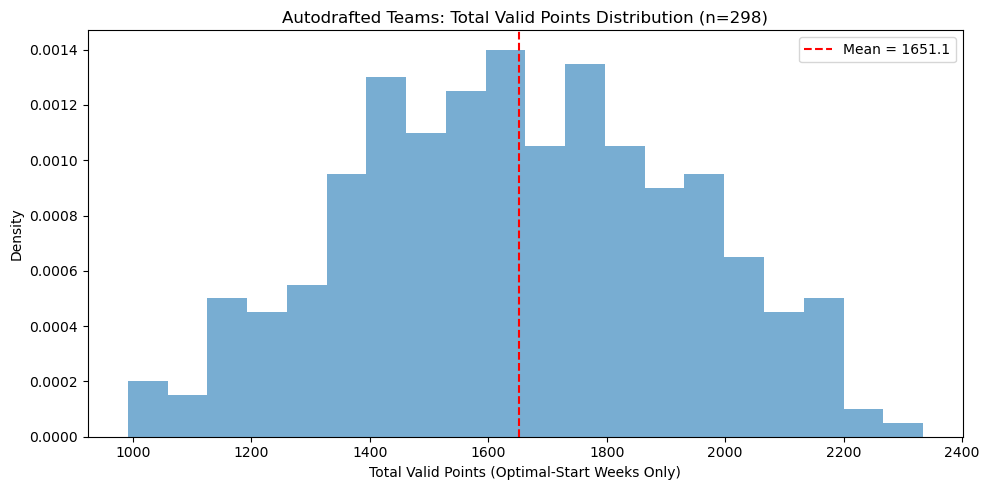

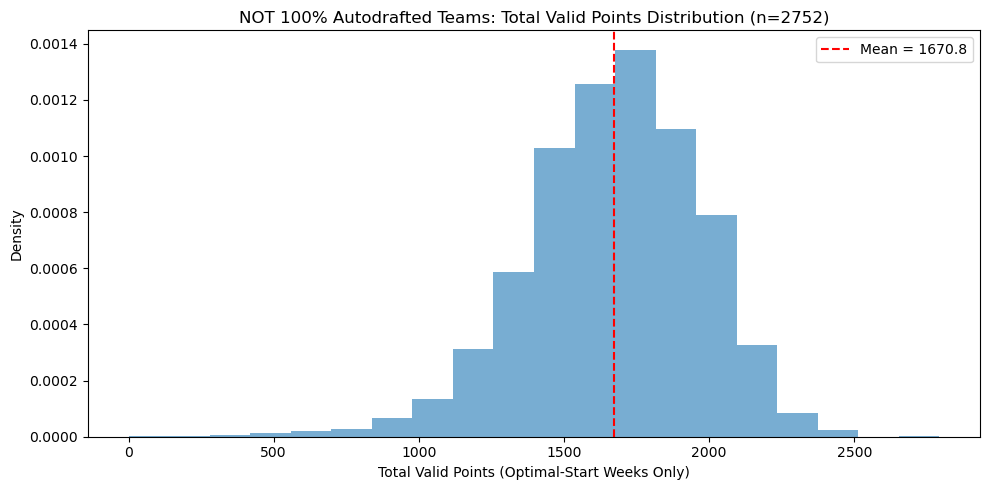

In [5]:
# Team Total Valid Points Distributions
# Compare autodrafted vs non-autodrafted teams

# Autodrafted teams
team_totals_auto = analyzer.plot_team_total_valid_points_distribution(
    fully_autodraft_only=True,
    bins=20
)

# Non-autodrafted teams
team_totals_non = analyzer.plot_team_total_valid_points_distribution(
    fully_autodraft_only=False,
    bins=20
)


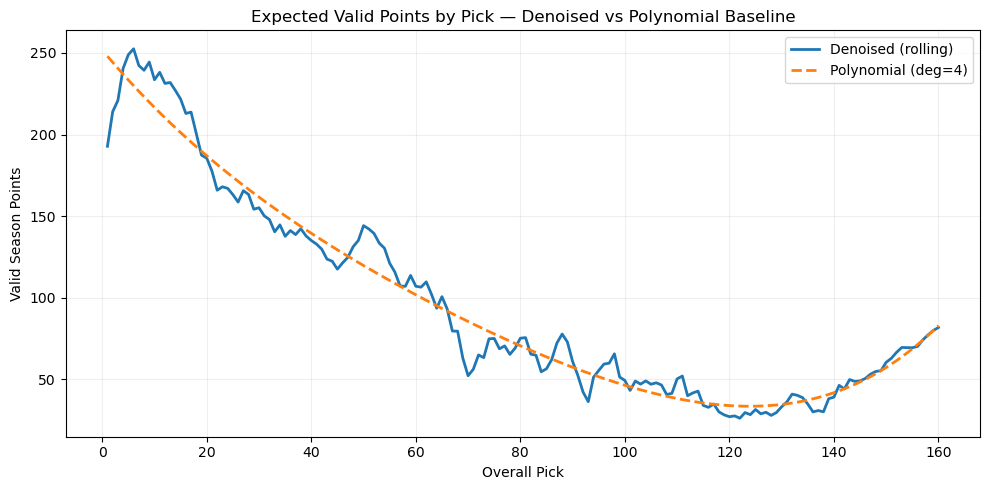

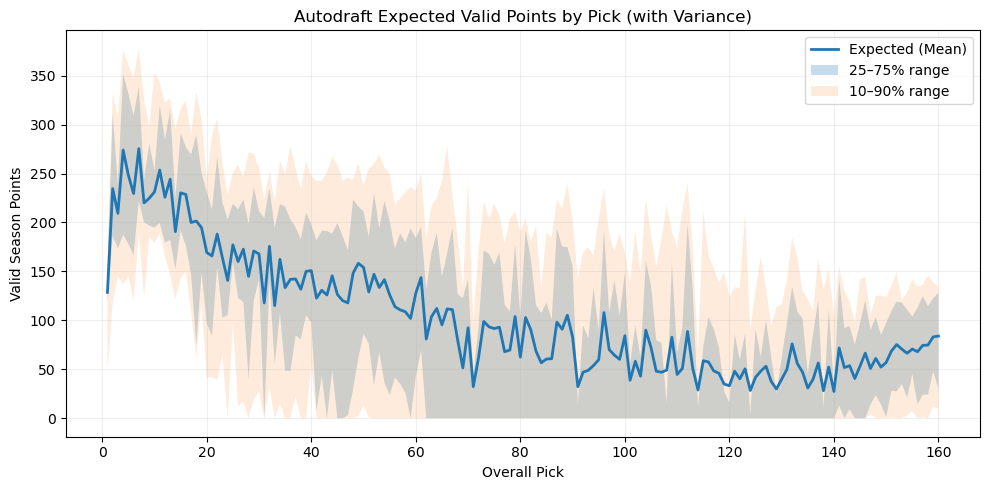

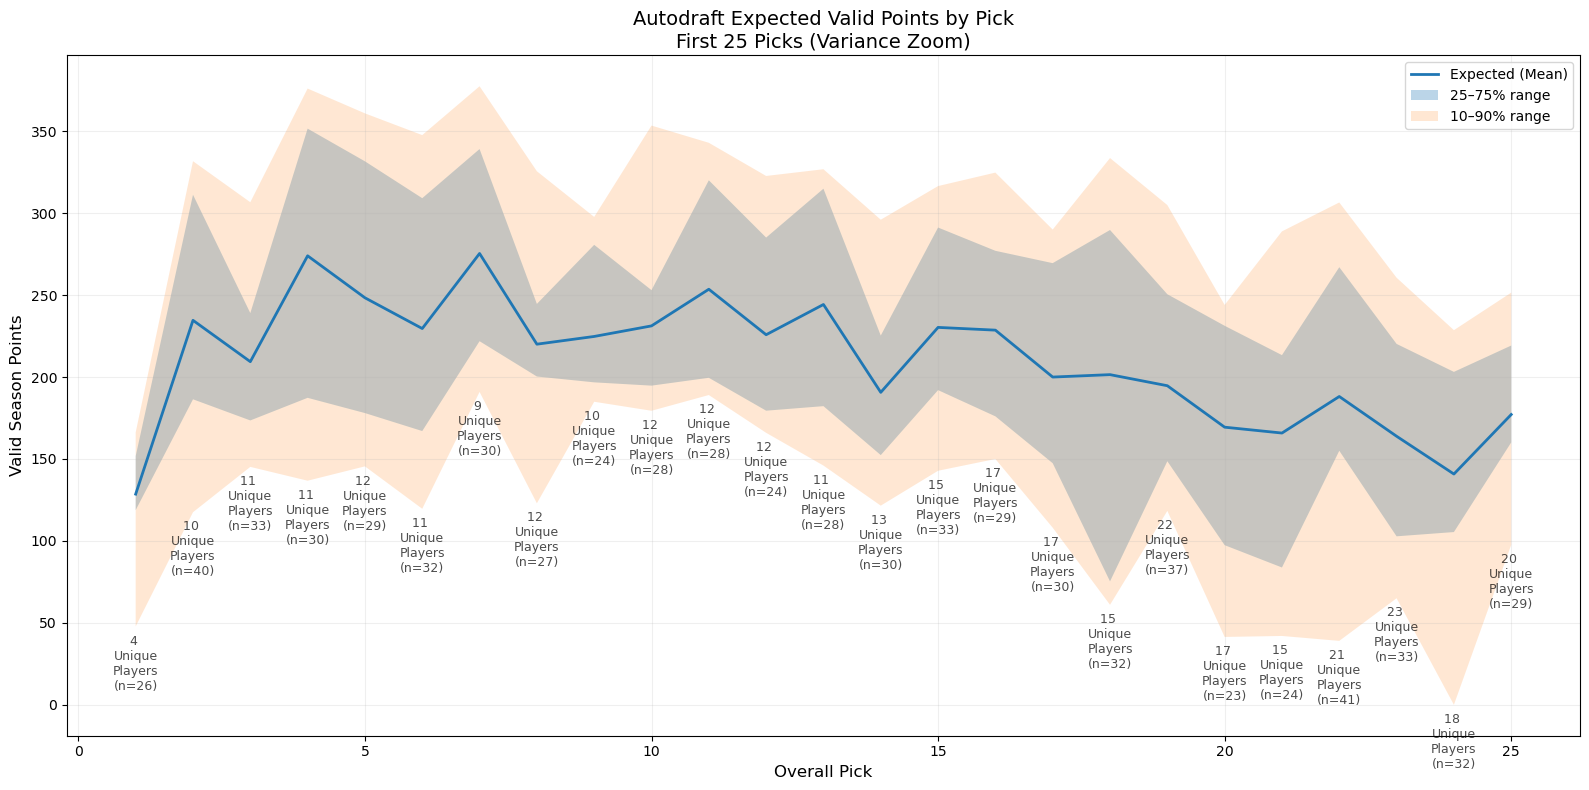

In [6]:
# Expected Value by Pick (with variance bands and polynomial fit)
analyzer.plot_expected_by_pick(
    expected_by_pick_pooled=expected_by_pick_pooled,
    expected_by_pick_poly=expected_by_pick_poly,
    show_variance=True,
    zoom_first_25=True  # Also show zoomed view of first 25 picks
)


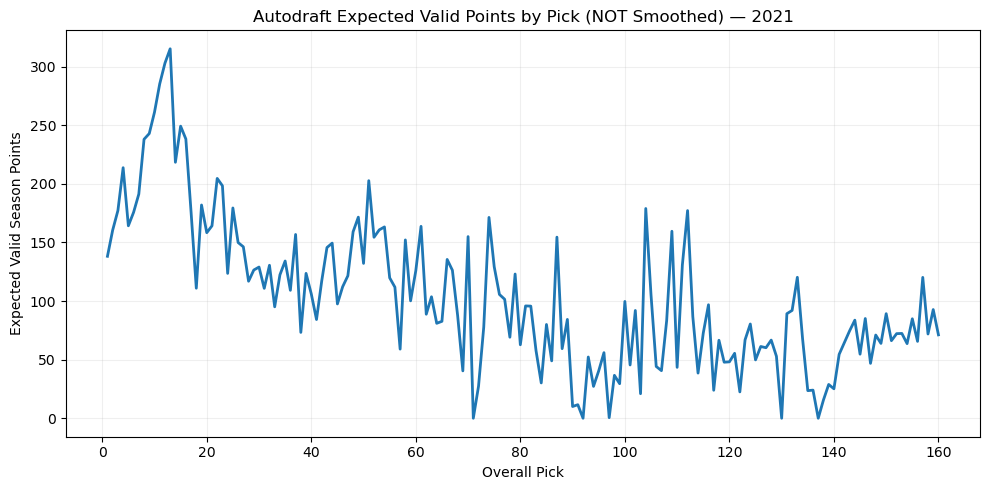

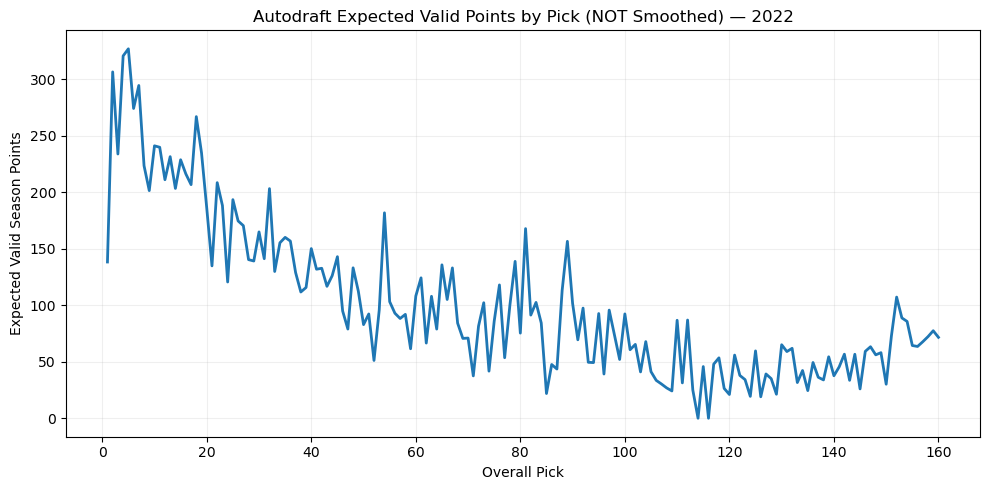

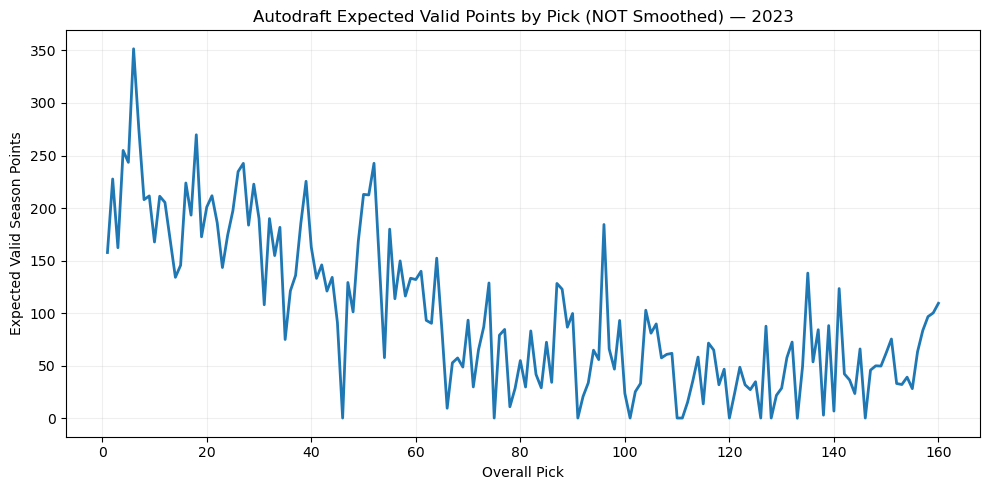

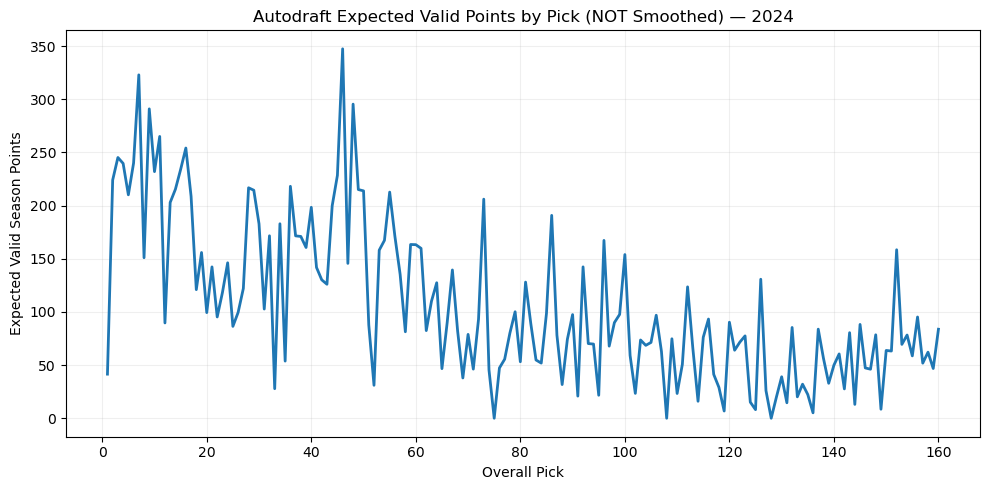

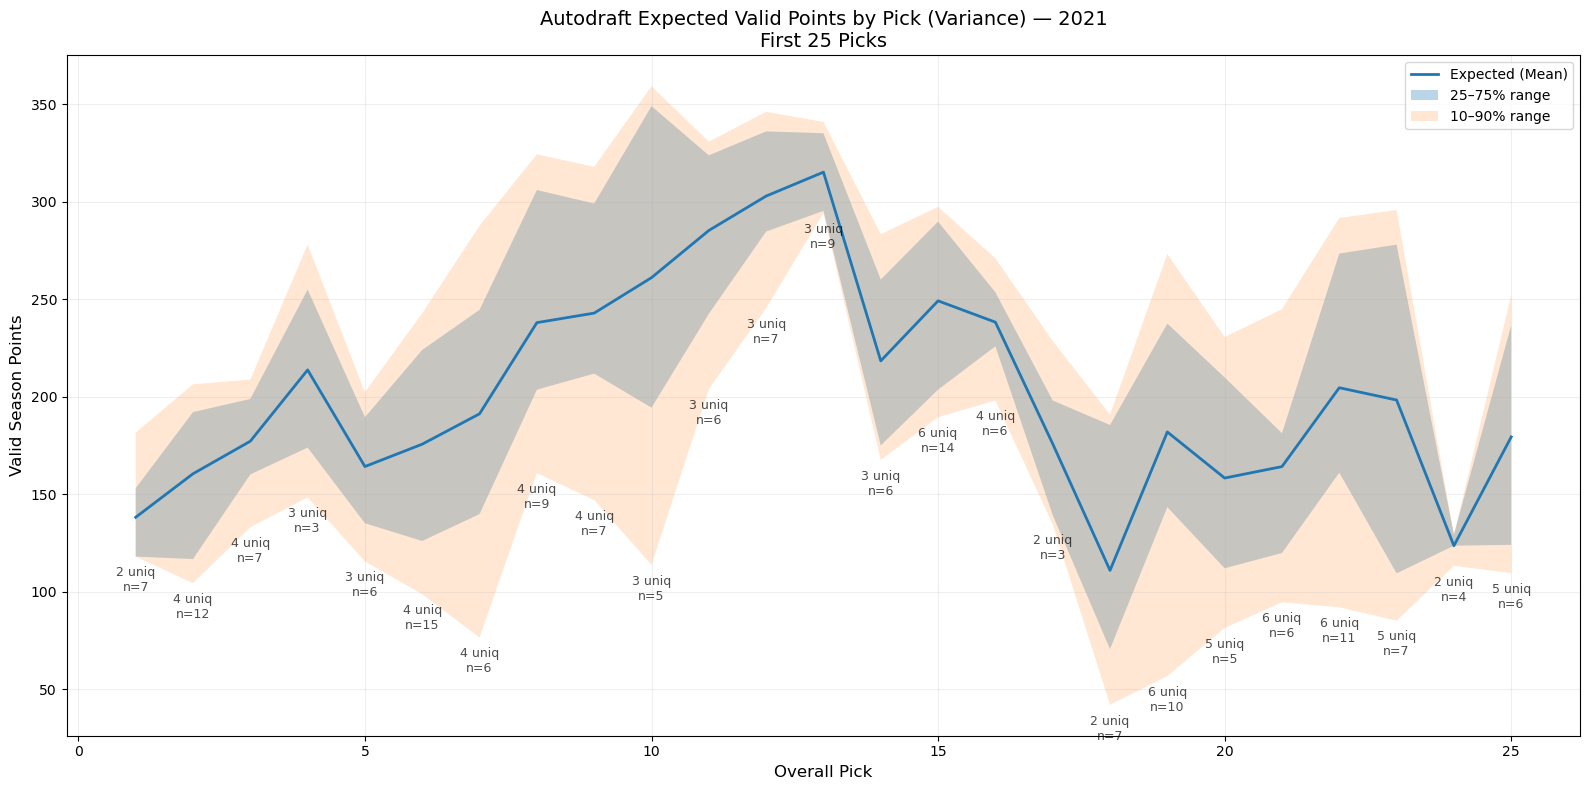

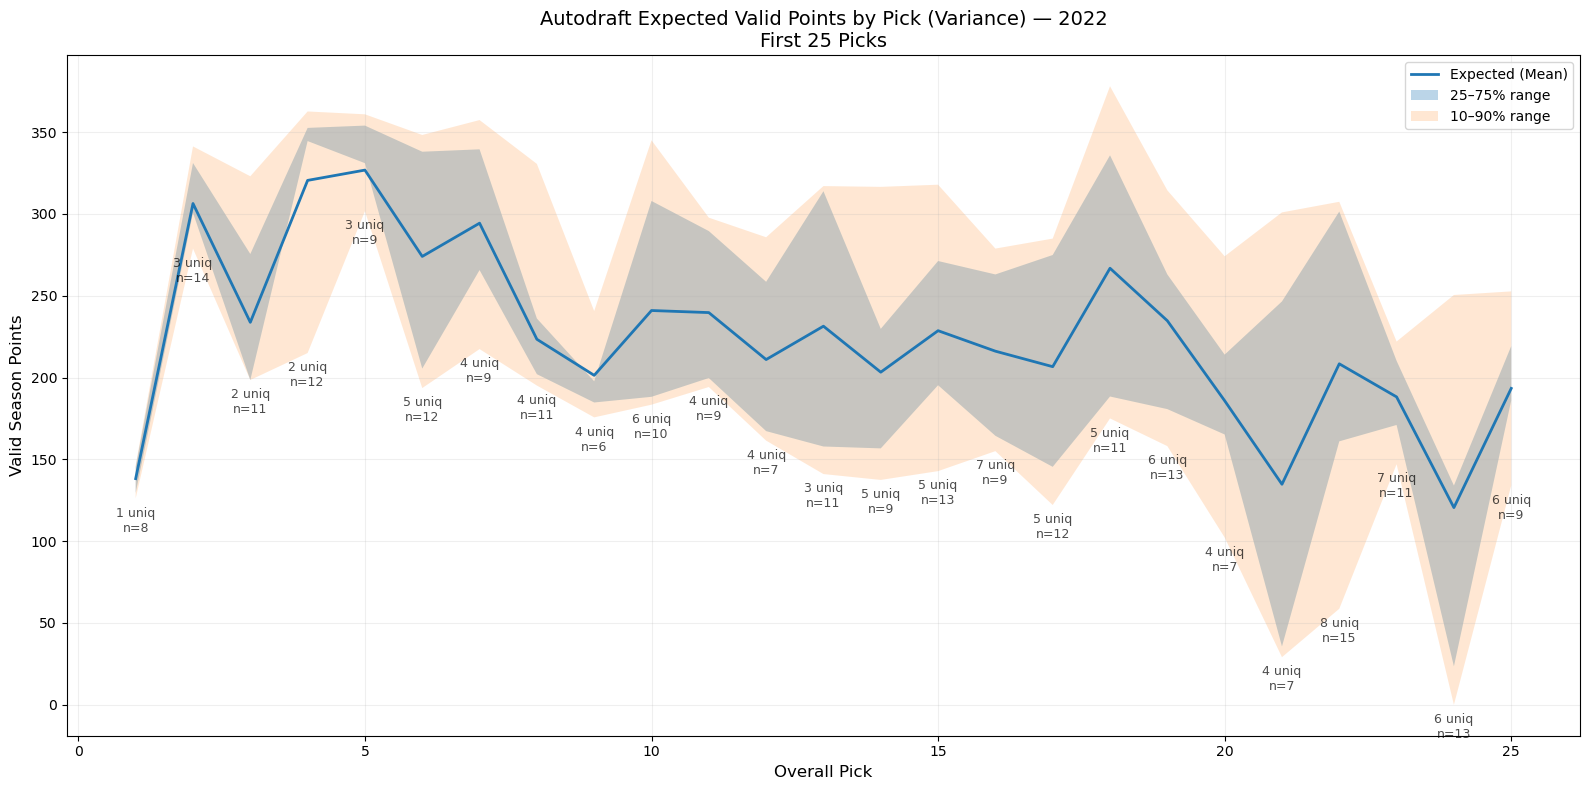

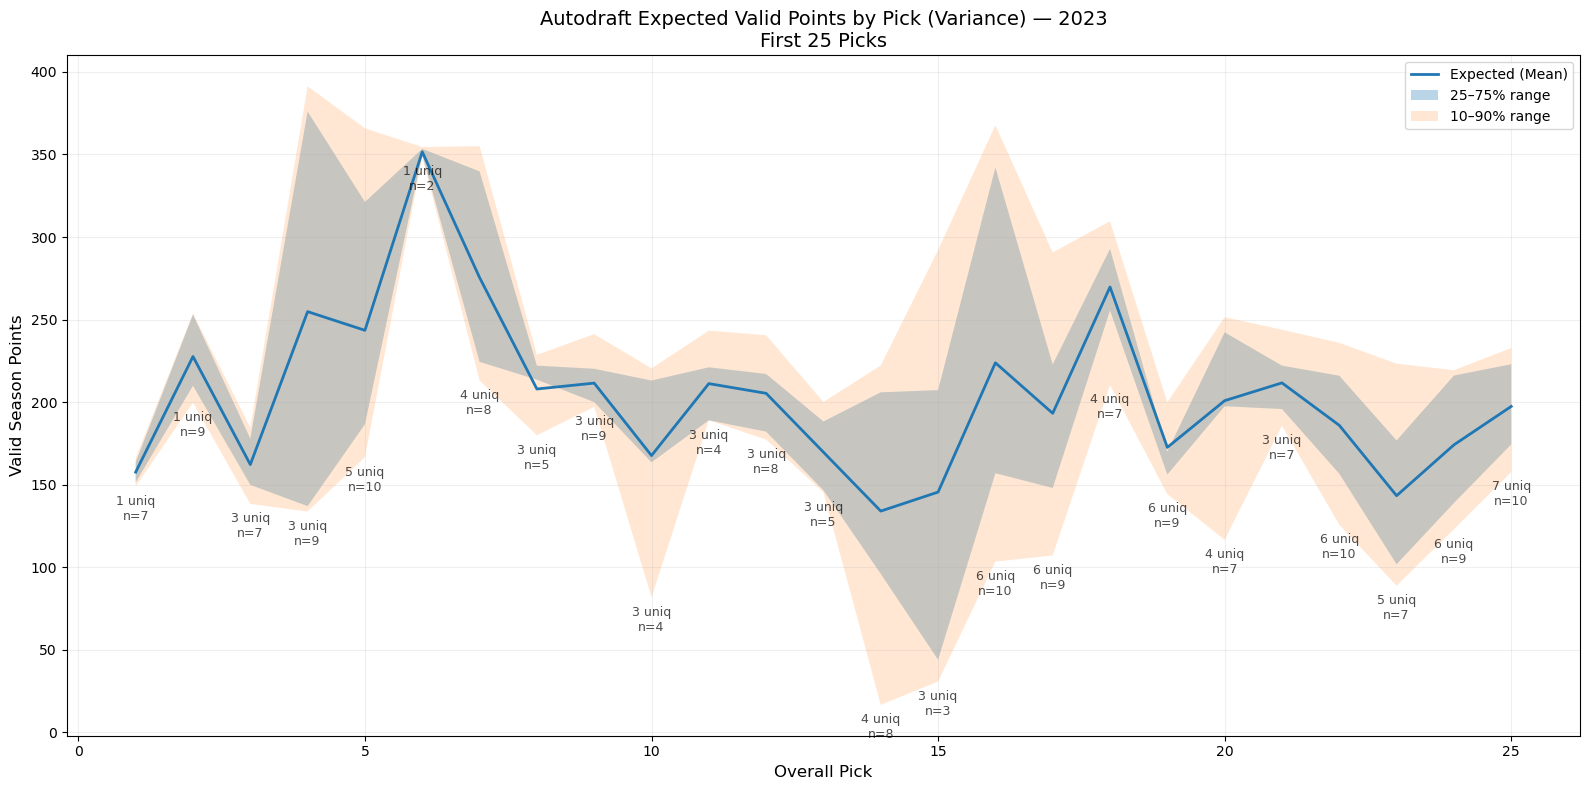

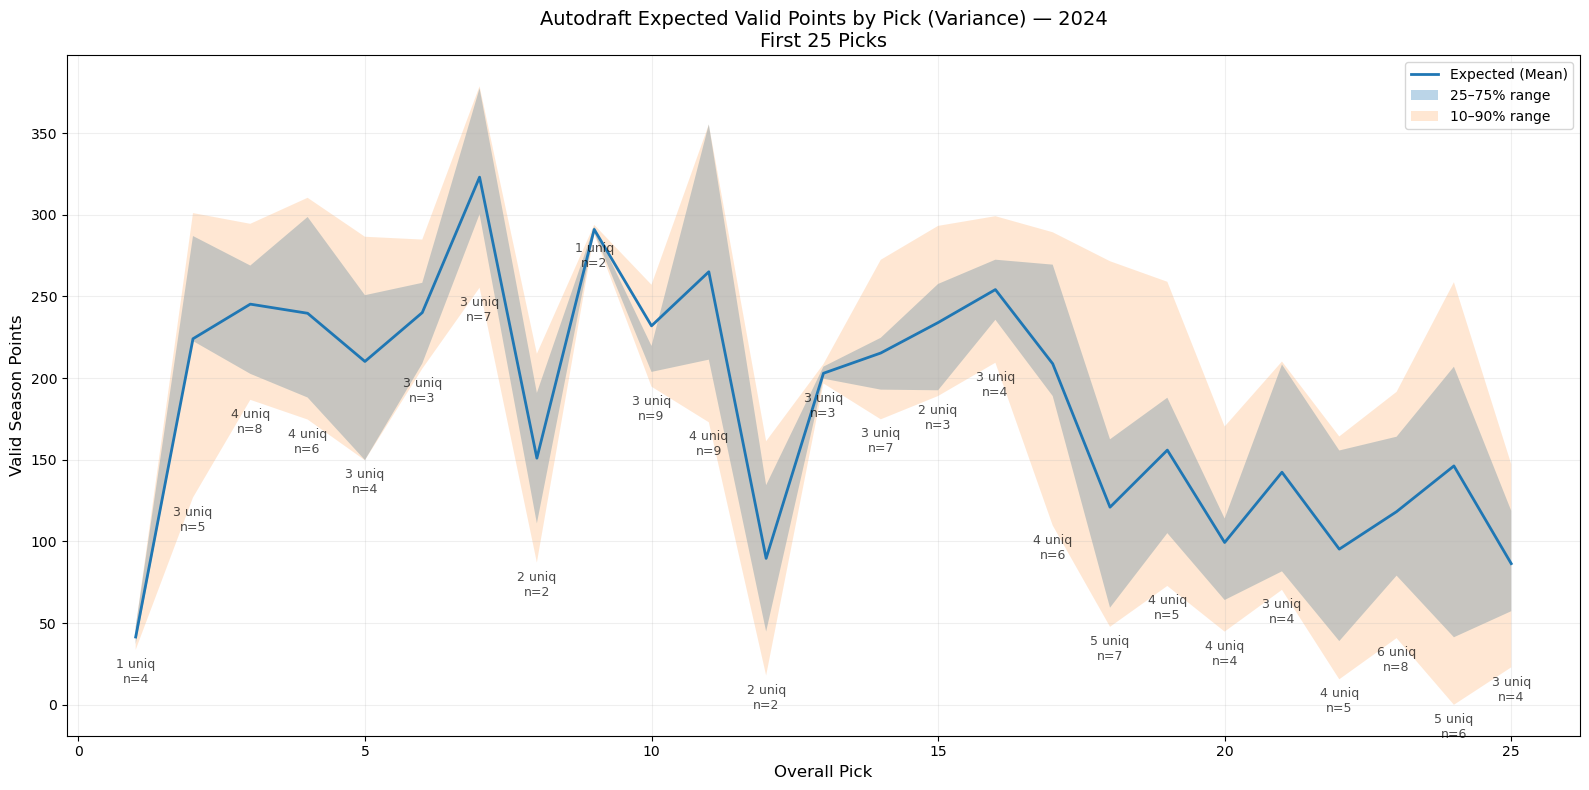

In [7]:
# Per-Season Expected Values
# Shows how expected values vary by year
analyzer.plot_per_season_expected_values(zoom_first_25=True)


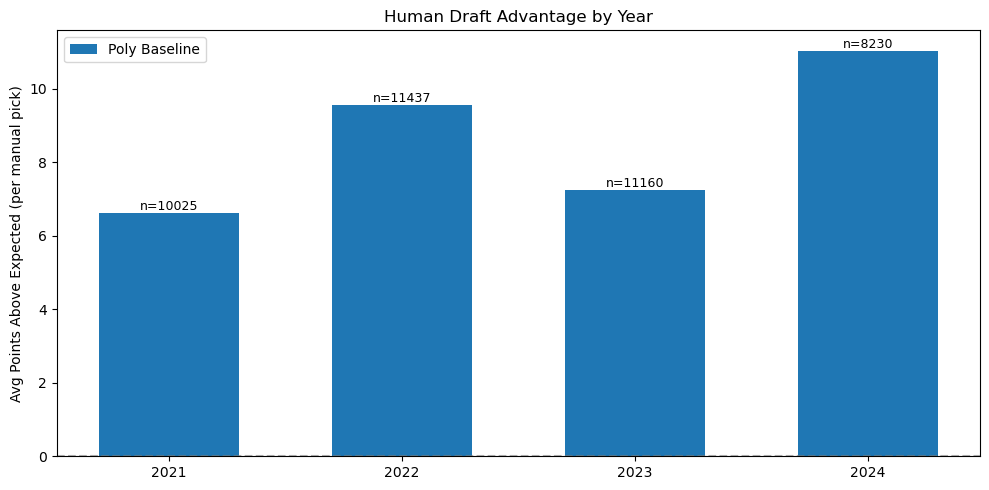


Human Advantage by Year:
   Year  Manual_Picks  Avg_Points_Added
0  2021         10025          6.636552
1  2022         11437          9.566188
2  2023         11160          7.249853
3  2024          8230         11.044533


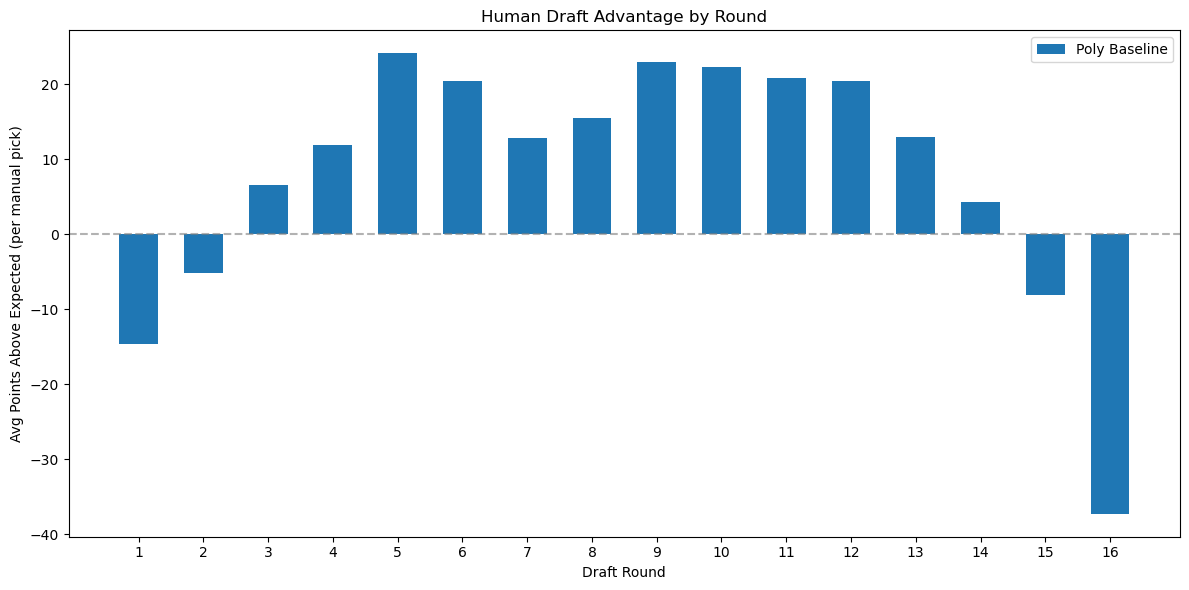


Human Advantage by Round:
   Round  Manual_Picks  Avg_Points_Added
0      1          2604        -14.714030
1      2          2625         -5.167479
2      3          2618          6.617339
3      4          2630         11.923182
4      5          2628         24.110433
5      6          2622         20.464581
6      7          2627         12.884405
7      8          2614         15.423253
8      9          2595         23.015415
9     10          2580         22.287893


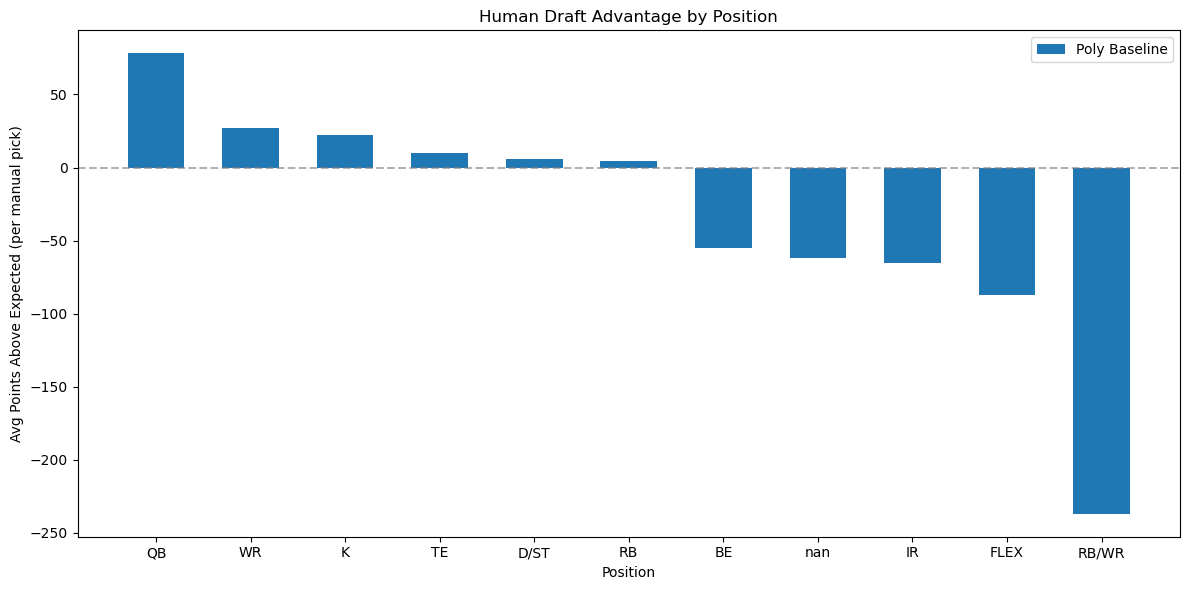


Human Advantage by Position:
   Position  Manual_Picks  Avg_Points_Added
5        QB          4002         78.155966
9        WR         10790         26.767684
4         K          2591         22.117724
8        TE          3849          9.721319
1      D/ST          2756          5.883762
6        RB          9727          4.486550
0        BE          6221        -55.251297
10      NaN           451        -61.954611
3        IR           192        -65.709080
2      FLEX           271        -87.414750
7     RB/WR             2       -236.998309


In [8]:
# Human Draft Advantage Analysis
# Compare manual picks vs autodraft baseline

# By Year
advantage_by_year = analyzer.plot_human_advantage_by_year(baseline="Poly")
print("\nHuman Advantage by Year:")
print(advantage_by_year)

# By Round
advantage_by_round = analyzer.plot_human_advantage_by_round(baseline="Poly")
print("\nHuman Advantage by Round:")
print(advantage_by_round.head(10))

# By Position
advantage_by_position = analyzer.plot_human_advantage_by_position(baseline="Poly")
print("\nHuman Advantage by Position:")
print(advantage_by_position)


#### Injury Data Collection

Collect NFL injury data for analysis. This data will be used to analyze how injuries affect player performance.


In [9]:
# Collect injury data for years 2021-2024
from src.data_fetchers.data_collector import collect_injury_data

injury_results = collect_injury_data(
    years=range(2021, 2025),
    output_dir="data/raw/injuries"
)

print(f"\n✓ Collected injury data for {injury_results['total_years']} years")
print(f"  Total records: {injury_results['total_records']:,}")



Output directory: data/raw/injuries

Fetching injury data for 2021...
  ✓ Saved 5,587 records to data/raw/injuries/nfl_injuries_2021.csv (0.4s)

Fetching injury data for 2022...
  ✓ Saved 5,682 records to data/raw/injuries/nfl_injuries_2022.csv (0.3s)

Fetching injury data for 2023...
  ✓ Saved 5,599 records to data/raw/injuries/nfl_injuries_2023.csv (0.3s)

Fetching injury data for 2024...
  ✓ Saved 6,215 records to data/raw/injuries/nfl_injuries_2024.csv (0.3s)

INJURY DATA COLLECTION COMPLETE!
Total years processed: 4
Total records: 23,083

✓ Collected injury data for 4 years
  Total records: 23,083


#### Injury Impact Analysis

Analyze how injuries affect player performance:
1. **Point Differential Analysis**: Compare actual vs projected points for injured vs healthy players
2. **Injury Type Impact**: How different injury types (hamstring, wrist, ankle, etc.) affect performance
3. **Position-Specific Impact**: How injuries affect different positions (QB, RB, WR, TE)
4. **Recovery Timeline**: Track performance over consecutive injury weeks
5. **Decision Support**: Help decide whether to start an injured player vs healthy alternative


In [ ]:
# Initialize Injury Analyzer
from src.analysis.injury_analyzer import InjuryAnalyzer

injury_analyzer = InjuryAnalyzer(
    injury_dir="data/raw/injuries",
    lineup_data_path=None,  # Auto-detect from data/raw/espn
    years=range(2021, 2025),
    verbose=True
)

# OPTION 1: Run full pipeline (all at once)
# This is now optimized and should be much faster (~2-5 minutes instead of 30+)
agg_stats, individual_records = injury_analyzer.run_full_analysis(
    save_results=True,
    output_dir="data/preprocessed"
)

print(f"\n✓ Analysis complete!")
print(f"  Aggregated statistics: {len(agg_stats):,} combinations")
print(f"  Individual records: {len(individual_records):,} player-weeks")

# OPTION 2: Run step-by-step (uncomment to use instead of Option 1)
# This allows you to see progress and work between steps
# Step 1: Load data (~30-60 seconds)
# injury_analyzer.load_injury_data()
# injury_analyzer.load_lineup_data()

# Step 2: Calculate baselines (~30 seconds - now optimized!)
# injury_analyzer.calculate_player_baselines()

# Step 3: Merge data (~30 seconds)
# injury_analyzer.merge_injury_lineup_data()

# Step 4: Track consecutive injuries (~30 seconds - now optimized!)
# injury_analyzer.track_consecutive_injuries()

# Step 5: Analyze impact (~30 seconds)
# agg_stats, individual_records = injury_analyzer.analyze_injury_impact()

# Save results
# import pandas as pd
# from pathlib import Path
# output_dir = Path("data/preprocessed")
# output_dir.mkdir(parents=True, exist_ok=True)
# agg_stats.to_csv(output_dir / "injury_impact_aggregated.csv", index=False)
# individual_records.to_csv(output_dir / "injury_impact_individual.csv", index=False)


Initializing InjuryAnalyzer...

RUNNING FULL INJURY ANALYSIS PIPELINE

Loading injury data...
  ✓ Loaded 5,587 records from 2021
  ✓ Loaded 5,682 records from 2022
  ✓ Loaded 5,599 records from 2023
  ✓ Loaded 6,215 records from 2024

  Total injury records: 22,203
  Years: 2021 - 2024
  Unique players: 2,649
  Injury statuses: {'No Injury': 11797, 'Questionable': 5853, 'Out': 3920, 'Doubtful': 627, 'Note': 6}

Loading lineup data...
  ✓ Loaded 664,182 records from 2021
  ✓ Loaded 862,267 records from 2022
  ✓ Loaded 984,778 records from 2023
  ✓ Loaded 709,251 records from 2024

  Total lineup records: 3,220,478
  Years: 2021 - 2024
  Unique players: 1,420

Calculating player baselines (healthy week performance)...
  Calculated baselines for 1,418 players
  Average baseline: -0.81 points
  Players with 1+ healthy weeks: 1,418
  Players with 5+ healthy weeks: 1,228

Merging injury and lineup data...
  Merged 3,221,164 records
  Injury weeks: 299,249
  Healthy weeks: 2,921,915

Tracking

#### Injury Impact Visualizations

Create visualizations to understand injury impact patterns.


In [ ]:
# Heatmap 1: Injury Type × Position
import matplotlib.pyplot as plt
injury_analyzer.plot_heatmap_type_position()
plt.show()


In [ ]:
# Heatmap 2: Injury Type × Status
injury_analyzer.plot_heatmap_type_status()
plt.show()


In [ ]:
# Heatmap 3: Position × Status
injury_analyzer.plot_heatmap_position_status()
plt.show()


In [ ]:
# Recovery Timeline by Injury Type
# Shows how performance changes over consecutive weeks with the same injury
injury_analyzer.plot_recovery_timeline_by_type()
plt.show()


In [ ]:
# Recovery Timeline by Injury Status
# Shows how performance changes over consecutive weeks by status (Questionable, Doubtful, Out)
injury_analyzer.plot_recovery_timeline_by_status()
plt.show()


In [ ]:
# Point Differential Distribution
# Compare distributions of point differentials for injured vs healthy players
injury_analyzer.plot_point_differential_distribution()
plt.show()


In [ ]:
# Preview aggregated statistics
print("Top 10 Injury Impact Combinations (by average point differential):")
print(agg_stats.nlargest(10, 'avg_point_differential')[['injury_type', 'position', 'injury_status', 'n_weeks', 'n_players', 'avg_point_differential']])

print("\n\nBottom 10 Injury Impact Combinations (worst performers):")
print(agg_stats.nsmallest(10, 'avg_point_differential')[['injury_type', 'position', 'injury_status', 'n_weeks', 'n_players', 'avg_point_differential']])
